In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

The process of training the model is as follows:
- 3 epochs to unfreeze three layers. Unfreeze one layer per epoch.
- 10 epochs, using stronger augmentation.
- 6 epochs, using lighter augmentation.



In [ ]:
# load pretrained model
model = models.resnet50(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# modify the output layer
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=10)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def freeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = False
    return model


def unfreeze_last_fc(model):
    for param in model.fc.parameters():
        param.requires_grad = True
    return model


def unfreeze_layer_by_name(model, layer_name):
    layer = getattr(model, layer_name)
    for param in layer.parameters():
        param.requires_grad = True
    return model

In [ ]:
def check_accuracy(loader, model):
    """
    Checks the accuracy of the model on the given dataset loader.
    """
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        # calculate accuracy
        accuracy = float(num_correct) / float(num_samples) * 100
        return accuracy


In [ ]:
translate = {"cane": "dog", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo", "ragno": "spider"}

def translate_class(class_name):
    return translate[class_name] if class_name in translate else class_name

In [ ]:
# light augmentation
transform_train_data = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.51775634, 0.5003316, 0.41256544], [0.271141, 0.26631165, 0.28339595])
])

In [ ]:
# strong augmentation
transform_train_data = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.51775634, 0.5003316, 0.41256544], [0.271141, 0.26631165, 0.28339595])

])

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
batch_size = 128
dataset_path = '/kaggle/input/animals-10/raw-img'

transform_test_data = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.51775634, 0.5003316, 0.41256544], [0.271141, 0.26631165, 0.28339595])
])

full_dataset = datasets.ImageFolder(root=dataset_path)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size


generator = torch.Generator().manual_seed(random_seed)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size],
                                                       generator=generator)

train_ds = Subset(datasets.ImageFolder(root=dataset_path, transform=transform_train_data), train_dataset.indices)
val_ds = Subset(datasets.ImageFolder(root=dataset_path, transform=transform_train_data), val_dataset.indices)
test_ds = Subset(datasets.ImageFolder(root=dataset_path, transform=transform_test_data), test_dataset.indices)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size * 2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=4, pin_memory=True)

print(f'Train size: {train_size}. Val size: {val_size}. Test size: {test_size}')

Train size: 18325. Val size: 2617. Test size: 5237


In [ ]:
model = freeze_all_layers(model)
model = unfreeze_last_fc(model)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

learning_rates = []
epochs_happened = 0

layers_to_unfreeze = ['layer4', 'layer3', 'layer2'] # starting with the layers closer to the output

In [ ]:
scheduler = StepLR(optimizer, step_size=8, gamma=0.2)

In [ ]:
# train neural network

for epoch in range(2):
    epochs_happened += 1

    #layer_name = layers_to_unfreeze[epoch]
    #model = unfreeze_layer_by_name(model, layer_name)

    model.train()
    running_loss = 0.0

    for batch_index, (images, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dl)
    epoch_accuracy = check_accuracy(train_dl, model)

    # save for later
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epochs_happened}\nTraining loss: {epoch_loss:.4f}\nAccuracy on train set: {epoch_accuracy:.4f}')


    # on validation set
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
         for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()


    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    val_accuracy = check_accuracy(val_dl, model)
    val_accuracies.append(val_accuracy)

    print(f'Validation loss: {val_loss:.4f}')
    print(f'Accuracy on validation set: {val_accuracy:.4f}')
    print()

    scheduler.step()

Epoch 18
Training loss: 0.0230
Accuracy on train set: 99.5962
Validation loss: 0.1558
Accuracy on validation set: 96.3317

Epoch 19
Training loss: 0.0217
Accuracy on train set: 99.7162
Validation loss: 0.1575
Accuracy on validation set: 95.7585



# Evaluate the model on the test set

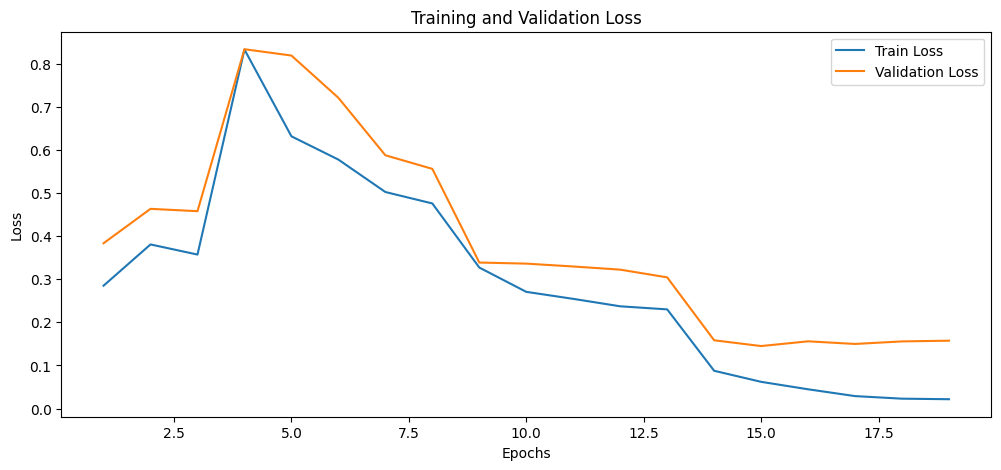

In [ ]:
epochs = range(1, epochs_happened + 1)
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

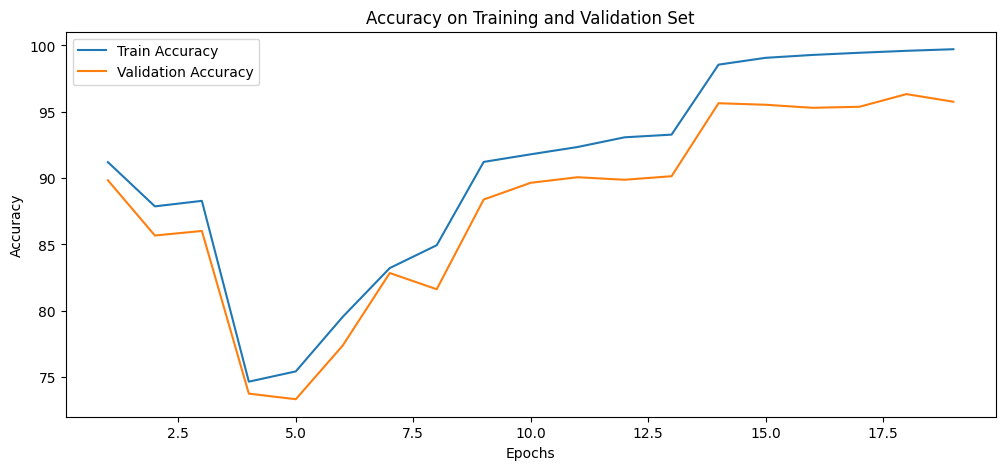

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy on Training and Validation Set')
plt.legend()

plt.show()

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)
f1 = f1_score(all_labels, all_preds, average=None)
conf_matrix = confusion_matrix(all_labels, all_preds)

overall_f1_weighted = f1_score(all_labels, all_preds, average="weighted")


class_names = full_dataset.classes
for i in range(len(class_names)):
    class_names[i] = translate_class(class_names[i])

print(f"Accuracy: {accuracy:.4f}")
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {class_names[i]} -> Precision: {p:.4f}, Recall: {r:.4f}, F1-score: {f:.4f}")

print()
print(f"Overall F1-score (Weighted): {overall_f1_weighted:.4f}")

Accuracy: 0.9681
Class dog -> Precision: 0.9576, Recall: 0.9789, F1-score: 0.9681
Class horse -> Precision: 0.9539, Recall: 0.9755, F1-score: 0.9646
Class elephant -> Precision: 0.9798, Recall: 0.9765, F1-score: 0.9782
Class butterfly -> Precision: 0.9634, Recall: 0.9814, F1-score: 0.9723
Class chicken -> Precision: 0.9669, Recall: 0.9734, F1-score: 0.9701
Class cat -> Precision: 0.9785, Recall: 0.9382, F1-score: 0.9580
Class cow -> Precision: 0.9487, Recall: 0.9276, F1-score: 0.9380
Class sheep -> Precision: 0.9595, Recall: 0.9197, F1-score: 0.9392
Class spider -> Precision: 0.9883, Recall: 0.9810, F1-score: 0.9846
Class squirrel -> Precision: 0.9816, Recall: 0.9790, F1-score: 0.9803

Overall F1-score (Weighted): 0.9680


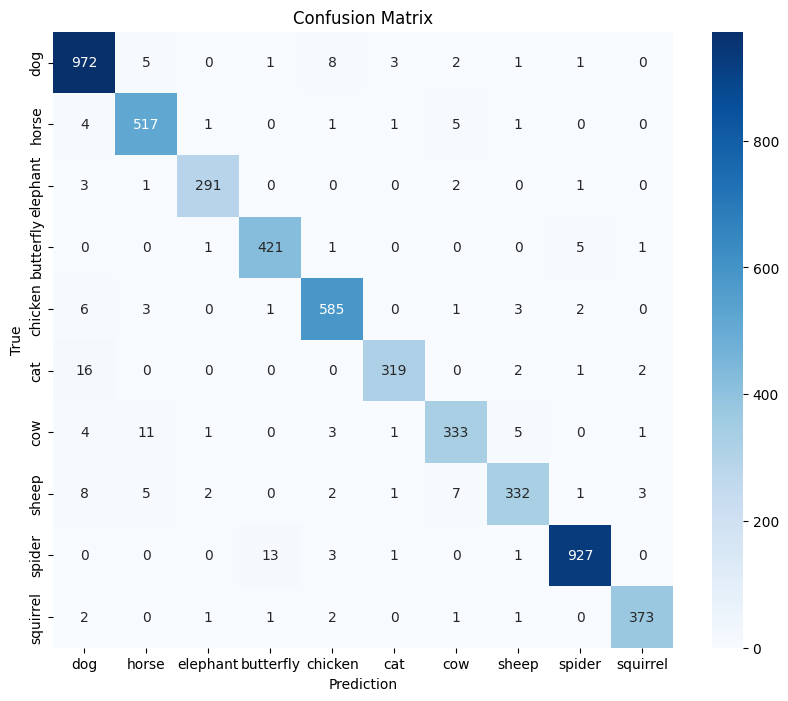

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Prediction")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# denormalization
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy() if isinstance(img, torch.Tensor) else img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# **Display some wrong predictions** 

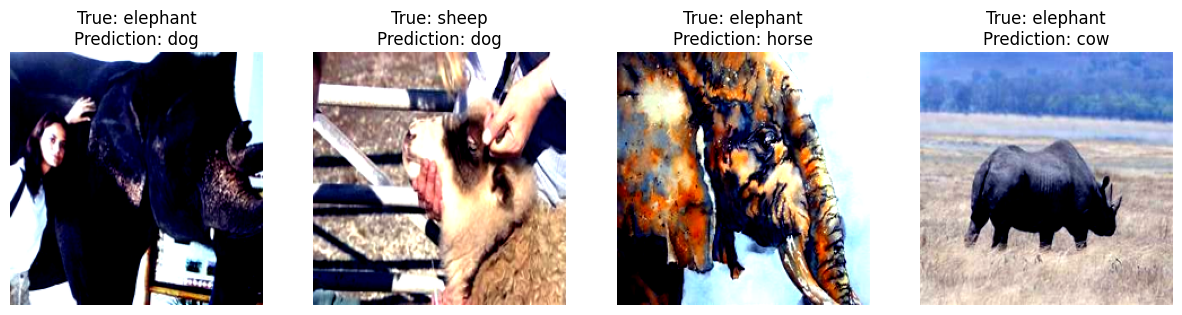

In [ ]:
model.eval()

data_iter = iter(test_loader)
images, labels = next(data_iter)

images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images)
    predictions = torch.argmax(outputs, dim=1)


images = images.cpu()
labels = labels.cpu().numpy()
predictions = predictions.cpu().numpy()

wrong_preds = [i for i in range(len(labels)) if labels[i] != predictions[i]]

plt.figure(figsize=(15, 5))

num_samples = min(5, len(wrong_preds))
for i, wrong_i in enumerate(wrong_preds[:num_samples]):
  plt.subplot(1, num_samples, i + 1)
  imshow(images[wrong_i])
  plt.title(f'True: {class_names[labels[wrong_i]]}\nPrediction: {class_names[predictions[wrong_i]]}', fontsize=12)
  plt.axis('off')
plt.show()


In [ ]:
torch.save(model.state_dict(), '/kaggle/working/model_best.pth')